In [4]:
import time
import math
import datetime
import pandas as pd
from pandas import DataFrame
from pandas import datetime
from pandas import read_csv
import numpy as np
from collections import deque

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_pickle('all_banks.pickle')
print(df.shape)
df.head()

(3216, 30)


Bank Ticker    BAC                                       C                \
Stock Info   Close   High    Low   Open      Volume  Close   High    Low   
Date                                                                       
2006-01-02   46.15  46.36  45.91  46.02         0.0  485.3  487.1  482.2   
2006-01-03   47.08  47.18  46.15  46.92  16197900.0  492.9  493.8  481.1   
2006-01-04   46.58  47.24  46.45  47.00  17427400.0  483.8  491.0  483.5   
2006-01-05   46.64  46.83  46.32  46.58  14668900.0  486.2  487.8  484.0   
2006-01-06   46.57  46.91  46.35  46.80  11965700.0  486.2  489.0  482.0   

Bank Ticker                    ...       MS                             \
Stock Info    Open     Volume  ...    Close     High      Low     Open   
Date                           ...                                       
2006-01-02   483.5        0.0  ...  47.1008  47.3333  46.7107  47.2751   
2006-01-03   490.0  1536700.0  ...  48.4041  48.5535  47.1008  47.4578   
2006-01-04   488.6  1852790.0  ...  48.4373  49.2093  48.4373  48.7278   
2006-01-05   484.4  1015470.0  ...  48.5701  48.6365  48.1634  48.6033   
2006-01-06   488.8  1358930.0  ...  48.6199  48.8524  48.1883  48.7860   

Bank Ticker                WFC                                      
Stock Info      Volume   Close    High     Low    Open      Volume  
Date                                                                
2006-01-02         0.0  31.415  31.535  31.215  31.415         0.0  
2006-01-03   6354408.0  31.900  31.975  31.195  31.600  11015000.0  
2006-01-04   9292188.0  31.530  31.820  31.365  31.800  10594000.0  
2006-01-05   6534262.0  31.495  31.555  31.310  31.500   9927600.0  
2006-01-06   8146445.0  31.680  31.775  31.385  31.580   8324000.0  

[5 rows x 30 columns]

In [6]:
close_df = df[df.columns[[df.columns[i][1]=='Close' for i in range(len(df.columns))]]]
close_df.columns = [close_df.columns[i][0] for i in range(len(close_df.columns))]
close_df.head()

,BAC,C,GS,JPM,MS,WFC
Date,,,,,,
2006-01-02,46.15,485.3,127.71,39.69,47.1008,31.415
2006-01-03,47.08,492.9,128.87,40.19,48.4041,31.900
2006-01-04,46.58,483.8,127.09,39.62,48.4373,31.530
2006-01-05,46.64,486.2,127.04,39.74,48.5701,31.495
2006-01-06,46.57,486.2,128.84,40.02,48.6199,31.680


In [40]:
GS_df = pd.DataFrame(data=close_df['GS'],index=close_df.index)
GS_df.columns = ['price']
GS_df.head()

,price
Date,
2006-01-02,127.71
2006-01-03,128.87
2006-01-04,127.09
2006-01-05,127.04
2006-01-06,128.84


In [32]:
str(GS_df.index[0]+(GS_df.index[-1] - GS_df.index[0])*0.7)[:10]

'2014-08-18'

In [9]:
print('There are {} number of days in the dataset.'.format(close_df.shape[0]))

There are 3216 number of days in the dataset.


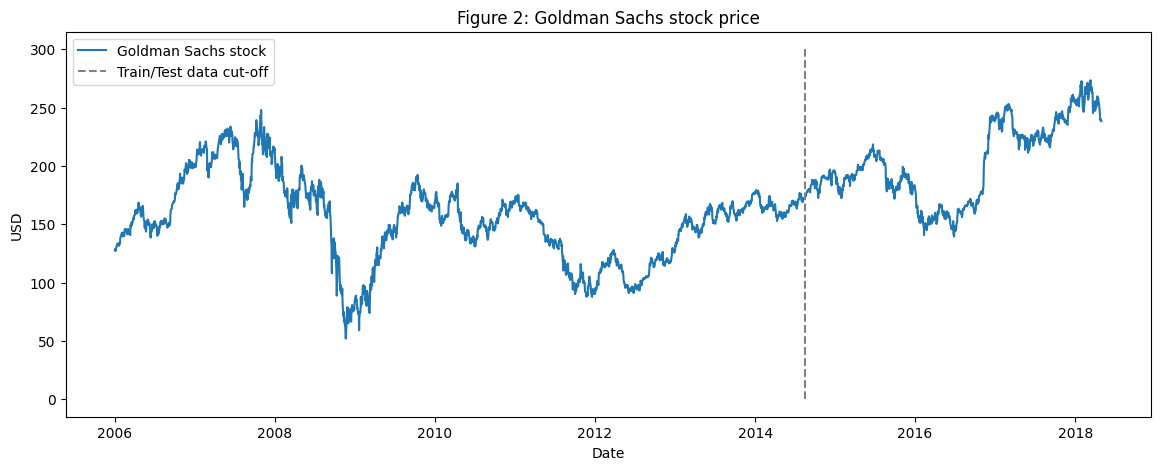

In [33]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(GS_df.index, GS_df['price'], label='Goldman Sachs stock')
plt.vlines(datetime.date(2014,8,18), 0, 300, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()

In [19]:
num_training_days = int(GS_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days,GS_df.shape[0]-num_training_days))

Number of training days: 2251. Number of test days: 965.


In [67]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['price'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['price'].ewm(span=26).mean()
    dataset['12ema'] = dataset['price'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['price'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['price'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['price']-1
    dataset['log_momentum'] = dataset['momentum'].apply(lambda x: math.log(x))
    
    return dataset

In [74]:
GS_df_TI = get_technical_indicators(GS_df)
GS_df_TI.head()

,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log-momentum,log_momentum
Date,,,,,,,,,,,,,
2006-01-02,127.71,NaN,NaN,127.710000,127.710000,0.000000,NaN,NaN,NaN,127.710000,126.71,4.841901,4.841901
2006-01-03,128.87,NaN,NaN,128.312308,128.338333,0.026026,NaN,NaN,NaN,128.580000,127.87,4.851014,4.851014
2006-01-04,127.09,NaN,NaN,127.873144,127.851109,-0.022036,NaN,NaN,NaN,127.548462,126.09,4.836996,4.836996
2006-01-05,127.04,NaN,NaN,127.640234,127.595073,-0.045160,NaN,NaN,NaN,127.205250,126.04,4.836599,4.836599
2006-01-06,128.84,NaN,NaN,127.918464,127.933315,0.014851,NaN,NaN,NaN,128.299587,127.84,4.850779,4.850779


In [111]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)    
    dataset = dataset.iloc[-last_days:, :]
    x_ =list(dataset.index)
    
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    plt.legend()
    plt.show()

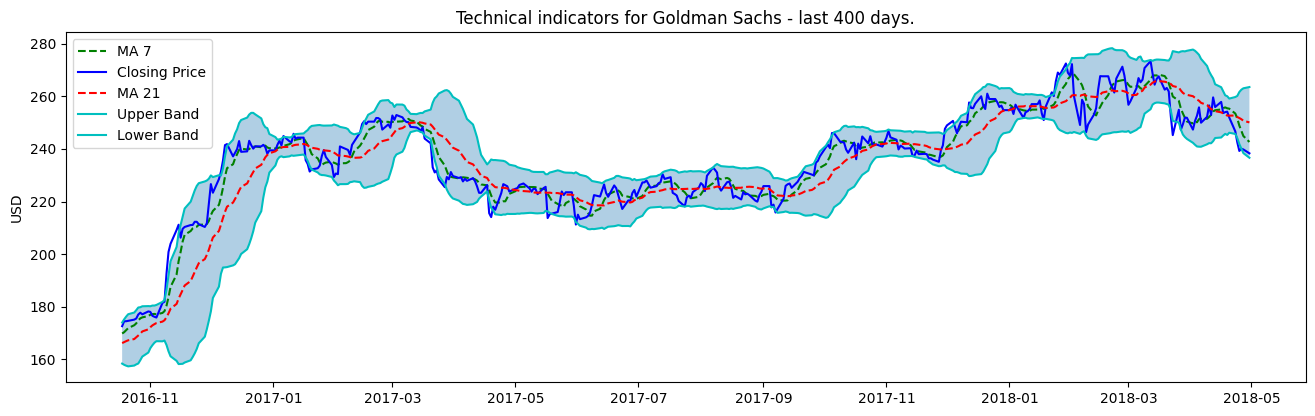

In [112]:
plot_technical_indicators(GS_df_TI, 400)

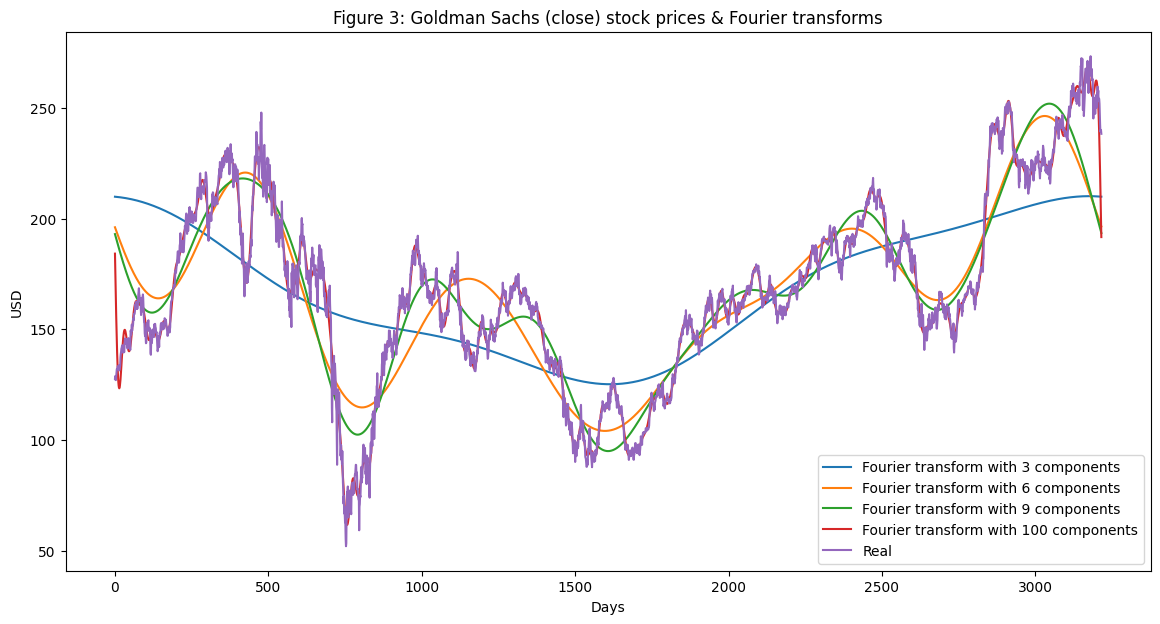

In [106]:
data_FT = GS_df
data_FT['date'] = data_FT.index
data_FT = data_FT.reset_index(drop=True)

close_fft = np.fft.fft(np.asarray(data_FT['price'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['price'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

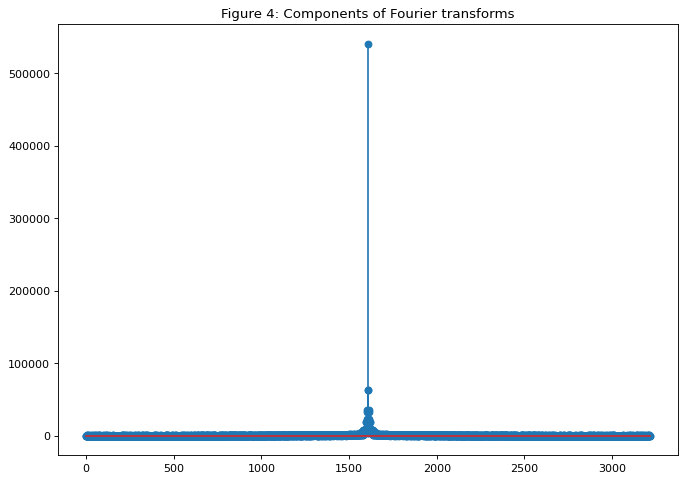

In [113]:
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

In [124]:
series = data_FT['price']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 3216
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8371.510
Date:                Fri, 28 Apr 2023   AIC                          16755.020
Time:                        17:31:05   BIC                          16791.474
Sample:                             0   HQIC                         16768.086
                               - 3216                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0532      0.012     -4.489      0.000      -0.076      -0.030
ar.L2         -0.0140      0.011     -1.296      0.195      -0.035       0.007
ar.L3          0.0114      0.013      0.842      0.4

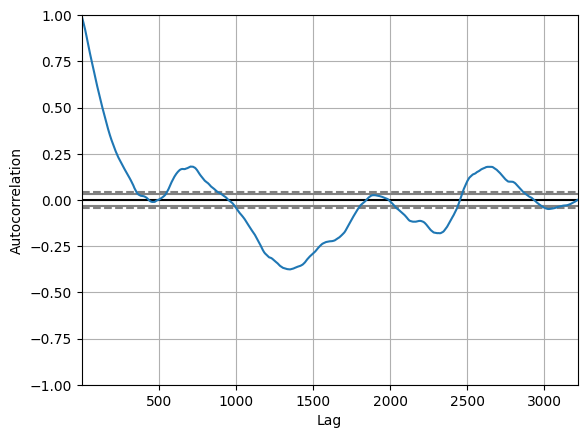

<Figure size 800x560 with 0 Axes>

In [122]:
pd.plotting.autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [126]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [127]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 7.557


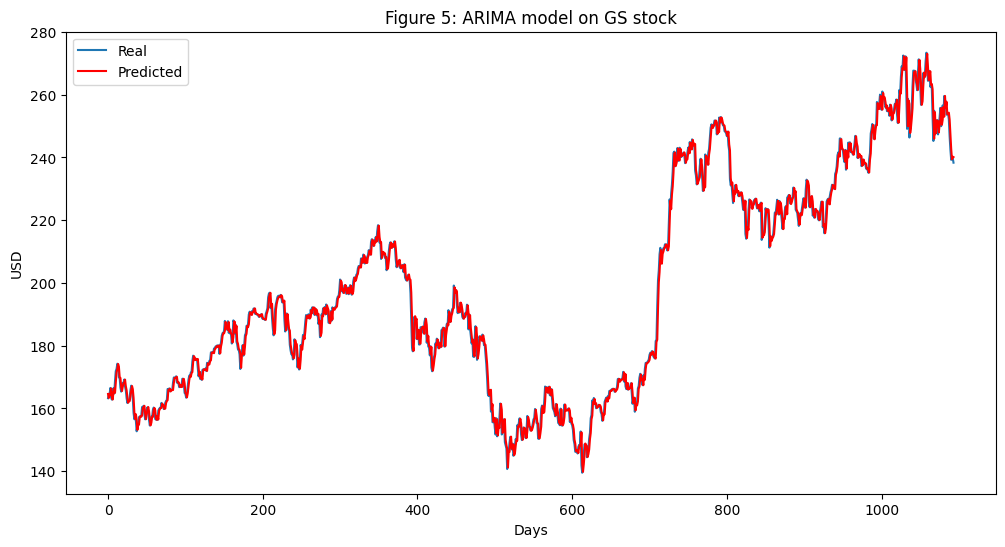

In [128]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

In [140]:
len(fft_list_m10)

3216

In [137]:
len(fft_list)

3216

In [134]:
series

0       127.71
1       128.87
2       127.09
3       127.04
4       128.84
         ...  
3211    242.49
3212    239.23
3213    240.09
3214    239.80
3215    238.33
Name: price, Length: 3216, dtype: float64

In [135]:
len(predictions)

1094

In [142]:
# print('Total dataset has {} samples, and {} features.'.format(dataset_total_df.shape[0], dataset_total_df.shape[1]))

In [143]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['price']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [148]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(GS_df_TI.drop(columns='date'))

In [188]:
regressor = xgb.XGBRegressor(grow_policy='lossguide',tree_method='exact',gamma=0.0,n_estimators=2000,max_depth=1024,base_score=1,colsample_bytree=1,
                             learning_rate=0.01)
xgbModel = regressor.fit(X_train_FI,y_train_FI, eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)],verbose=False)
eval_result = regressor.evals_result()
eval_result['validation_0']['rmse'][-1]

0.00087805793442991

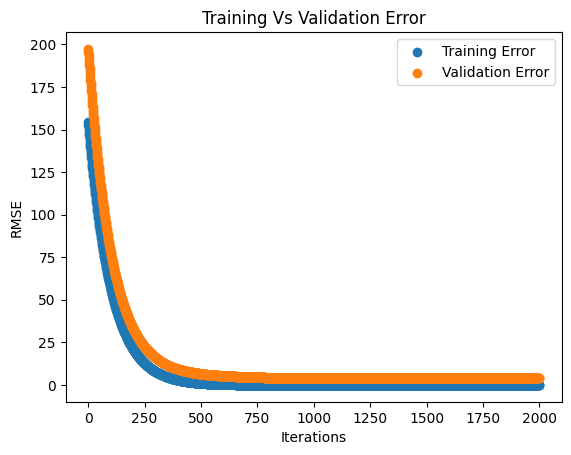

In [189]:
training_rounds = range(len(eval_result['validation_0']['rmse']))
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

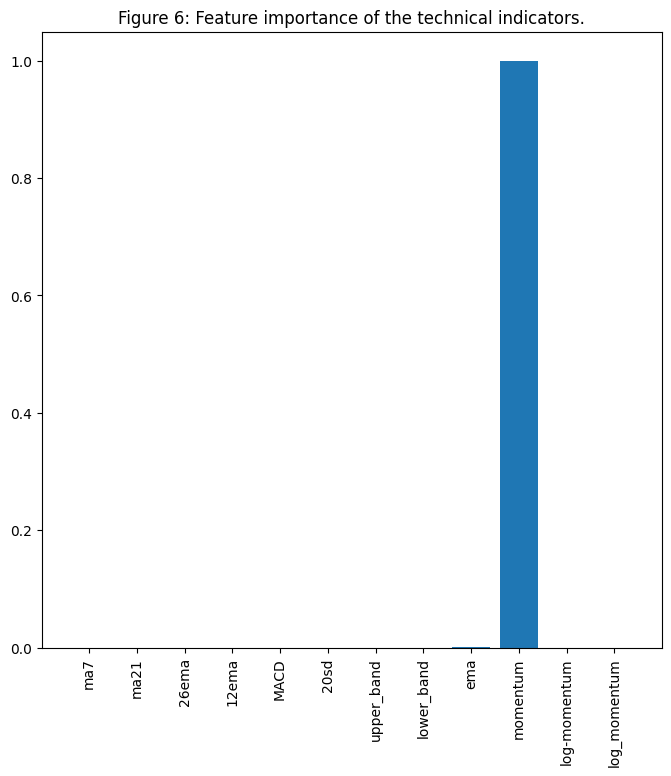

In [190]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()